# Regression Week 5: Feature Selection and LASSO (interpretation)

In this notebook, you will use LASSO to select features, building on a pre-implemented solver for LASSO. You will:
* Run LASSO with different L1 penalties.
* Choose best L1 penalty using a validation set.
* Choose best L1 penalty using a validation set, with additional constraint on the size of subset.

In the second notebook, you will implement your own LASSO solver, using coordinate descent. 

### Load libraries

In [1]:
from math import log, sqrt
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import Lasso
from sklearn.utils import shuffle

In [2]:
# load the data
dtype_dict = {'bathrooms':float, 'waterfront':int, 'sqft_above':int, 'sqft_living15':float, 'grade':int,
              'yr_renovated':int, 'price':float, 'bedrooms':float, 'zipcode':str, 'long':float, 'sqft_lot15':float,
              'sqft_living':float, 'floors':float, 'condition':int, 'lat':float, 'date':str, 'sqft_basement':int,
              'yr_built':int, 'id':str, 'sqft_lot':int, 'view':int}
sales = pd.read_csv('kc_house_data.csv', dtype=dtype_dict)
sales.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3.0,1.00,1180.0,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340.0,5650.0
1,6414100192,20141209T000000,538000.0,3.0,2.25,2570.0,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690.0,7639.0
2,5631500400,20150225T000000,180000.0,2.0,1.00,770.0,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720.0,8062.0
3,2487200875,20141209T000000,604000.0,4.0,3.00,1960.0,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360.0,5000.0
4,1954400510,20150218T000000,510000.0,3.0,2.00,1680.0,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800.0,7503.0


In [3]:
# create some new features
sales['sqft_living_sqrt'] = sales['sqft_living'].apply(sqrt)
sales['sqft_lot_sqrt'] = sales['sqft_lot'].apply(sqrt)
sales['bedrooms_square'] = sales['bedrooms']*sales['bedrooms']
sales['floors_square'] = sales['floors']*sales['floors']

- Squaring bedrooms will increase the separation between not many bedrooms (e.g. 1) and lots of bedrooms (e.g. 4) since 1^2 = 1 but 4^2 = 16. Consequently this variable will mostly affect houses with many bedrooms.
- On the other hand, taking square root of sqft_living will decrease the separation between big house and small house. The owner may not be exactly twice as happy for getting a house that is twice as big.

### Train regression weights with L1 penalty

Fit a model with all the features available, plus the newly created features, using a L1 penalty of 5e2. Make sure to add "normalize=True" when creating the Lasso object.

**Note.** From here on, the list 'all_features' refers to the list defined in this snippet.

In [4]:
all_features = ['bedrooms', 'bedrooms_square',
                'bathrooms',
                'sqft_living', 'sqft_living_sqrt',
                'sqft_lot', 'sqft_lot_sqrt',
                'floors', 'floors_square',
                'waterfront', 'view', 'condition', 'grade',
                'sqft_above',
                'sqft_basement',
                'yr_built', 'yr_renovated']

In [5]:
model_all = Lasso(alpha=5e2, normalize=True)
model_all.fit(sales[all_features], sales['price'])

Lasso(alpha=500.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=True, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

**Q1: which features have been chosen i.e. which were assigned non-zero weights?**

In [6]:
weights_df = pd.DataFrame(sales[all_features].columns, model_all.coef_).reset_index()
weights_df.columns=['weight', 'feature']
sub_df = weights_df.loc[weights_df.weight != 0]
sub_df

,weight,feature
3,134.439314,sqft_living
10,24750.004586,view
12,61749.103091,grade


Note that a majority of the weights have been set to zero. So by setting an L1 penalty that's large enough, we are performing a subset selection.

### Selecting an L1 penalty

To find a good L1 penalty, we will explore multiple values using a validation set. Let us do three way split into train, validation, and test sets. Download the provided csv files containing training, validation and test sets.

In [7]:
testing = pd.read_csv('wk3_kc_house_test_data.csv', dtype=dtype_dict)
training = pd.read_csv('wk3_kc_house_train_data.csv', dtype=dtype_dict)
validation = pd.read_csv('wk3_kc_house_valid_data.csv', dtype=dtype_dict)

Create the 4 features again for each dataset:

In [8]:
training['sqft_living_sqrt'] = training['sqft_living'].apply(sqrt)
training['sqft_lot_sqrt'] = training['sqft_lot'].apply(sqrt)
training['bedrooms_square'] = training['bedrooms']*training['bedrooms']
training['floors_square'] = training['floors']*training['floors']

validation['sqft_living_sqrt'] = validation['sqft_living'].apply(sqrt)
validation['sqft_lot_sqrt'] = validation['sqft_lot'].apply(sqrt)
validation['bedrooms_square'] = validation['bedrooms']*validation['bedrooms']
validation['floors_square'] = validation['floors']*validation['floors']

testing['sqft_living_sqrt'] = testing['sqft_living'].apply(sqrt)
testing['sqft_lot_sqrt'] = testing['sqft_lot'].apply(sqrt)
testing['bedrooms_square'] = testing['bedrooms']*testing['bedrooms']
testing['floors_square'] = testing['floors']*testing['floors']

Next, write a loop that does the following:
* For `l1_penalty` in [10^1, 10^1.5, 10^2, 10^2.5, ..., 10^7] (to get this in Python, type `np.logspace(1, 7, num=13)`.)
    * Fit a regression model with a given `l1_penalty` on the training data.
    * Compute the RSS on validation data (here you will want to use `.predict()`) for that `l1_penalty`
* Report which `l1_penalty` produced the lowest RSS on validation data.

In [9]:
RSS_list = []
penalty_list = np.logspace(1, 7, num=13)
for l1_penalty in penalty_list:
    model = Lasso(alpha=l1_penalty, normalize=True)
    model.fit(training[all_features], training['price'])
    
    preds = model.predict(validation[all_features])
    RSS = ((validation['price'] - preds)**2).sum()
    RSS_list.append(RSS)

RSS_df = pd.DataFrame(penalty_list, RSS_list).reset_index()
RSS_df.columns = ['RSS', 'penalty']
RSS_df

,RSS,penalty
0,3.982133e+14,1.000000e+01
1,3.990419e+14,3.162278e+01
2,4.297916e+14,1.000000e+02
3,4.637398e+14,3.162278e+02
4,6.458987e+14,1.000000e+03
5,1.222507e+15,3.162278e+03
6,1.222507e+15,1.000000e+04
7,1.222507e+15,3.162278e+04
8,1.222507e+15,1.000000e+05
9,1.222507e+15,3.162278e+05


**Q2: What was the best value for the l1_penalty i.e. which value produced the lowest validation RSS?**

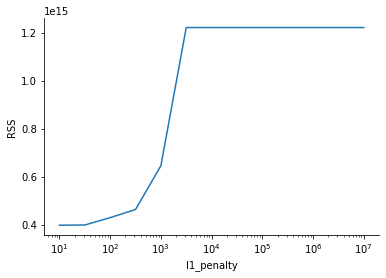

In [10]:
# plot the l2_penalty values in the x axis and the validation error in the y axis.
sns.lineplot(data=RSS_df, x="penalty", y="RSS")
plt.xscale('log')
plt.xlabel("l1_penalty")
sns.despine()

Now that you have selected an L1 penalty, compute the RSS on test data for the model with the best L1 penalty.

In [11]:
best_l1_penalty = RSS_df.iloc[np.argmin(RSS_df.RSS)]['penalty']

best_model = Lasso(alpha=best_l1_penalty, normalize=True)
best_model.fit(training[all_features], training['price'])

preds = best_model.predict(testing[all_features])
RSS = ((testing['price'] - preds)**2).sum()
RSS

98467402552698.81

**Q3: Using the best L1 penalty, how many nonzero weights do you have? Count the number of non-zero coefficients first, and add 1 if the intercept is also nonzero.**

In [12]:
np.count_nonzero(best_model.coef_) + np.count_nonzero(best_model.intercept_)

15

### Limit the number of non-zero weights

What if we absolutely wanted to limit ourselves to, say, 7 features? This may be important if we want to derive "a rule of thumb" --- an interpretable model that has only a few features in them.

In this section, you are going to implement a simple, two phase procedure to achive this goal:
1. Explore a large range of `l1_penalty` values to find a narrow region of `l1_penalty` values where models are likely to have the desired number of non-zero weights.
2. Further explore the narrow region you found to find a good value for `l1_penalty` that achieves the desired sparsity.  Here, we will again use a validation set to choose the best value for `l1_penalty`.

In [13]:
max_nonzeros = 7

#### Find a narrow range with the desired sparsity inside a larger range of values
Let's define a wide range of possible l1_penalty_values:

In [14]:
l1_penalty_values = np.logspace(1, 4, num=20)

Now, implement a loop that search through this space of possible l1_penalty values:

- For l1_penalty in np.logspace(8, 10, num=20):
    - Fit a regression model with a given `l1_penalty` on the training data. Add "alpha=l1_penalty" and "normalize=True" to the parameter list.
    - Extract the weights of the model and count the number of non-zeros. Save the number of non-zeros to a list.

In [15]:
nonzeros_list = []
for penalty in l1_penalty_values:
    model = Lasso(alpha=penalty, normalize=True)
    model.fit(training[all_features], training['price'])
    num_nonzeros = np.count_nonzero(model.coef_) + np.count_nonzero(best_model.intercept_)
    nonzeros_list.append(num_nonzeros)
#     print(penalty, " : ", num_nonzeros)

Out of this large range, we want to find the two ends of our desired narrow range of `l1_penalty`.  At one end, we will have `l1_penalty` values that have too few non-zeros, and at the other end, we will have an `l1_penalty` that has too many non-zeros.  

More formally, find:
- The largest `l1_penalty` that has more non-zeros than `max_nonzeros` (if we pick a penalty smaller than this value, we will definitely have too many non-zero weights)
    - Store this value in the variable `l1_penalty_min` (we will use it later)
- The smallest `l1_penalty` that has fewer non-zeros than `max_nonzeros` (if we pick a penalty larger than this value, we will definitely have too few non-zero weights)
    - Store this value in the variable `l1_penalty_max` (we will use it later)

*Hint: there are many ways to do this, e.g.:*
- Programmatically within the loop above
- Creating a list with the number of non-zeros for each value of `l1_penalty` and inspecting it to find the appropriate boundaries.

In [16]:
l1_penalty_max = l1_penalty_values.max()


for penalty in l1_penalty_values:
    model = Lasso(alpha=penalty, normalize=True)
    model.fit(training[all_features], training['price'])
    num_nonzeros = np.count_nonzero(model.coef_) + np.count_nonzero(best_model.intercept_)
    if num_nonzeros > max_nonzeros:
        l1_penalty_min = penalty
    if num_nonzeros < max_nonzeros:
        if penalty < l1_penalty_max:
            l1_penalty_max = penalty
        else:
            l1_penalty_max = l1_penalty_max

**Q4: What values did you find for `l1_penalty_min` and `l1_penalty_max`?**

In [17]:
print("Min L1 penalty: ", str(l1_penalty_min))
print("Max L1 penalty: ", str(l1_penalty_max))

Min L1 penalty:  127.42749857031335
Max L1 penalty:  263.6650898730358


#### Exploring the narrow range of values

We now explore the region of l1_penalty we found between `l1_penalty_min` and `l1_penalty_max`. We look for the L1 penalty in this range that produces exactly the right number of nonzeros and also minimizes RSS on the validation set.

In [18]:
l1_penalty_values = np.linspace(l1_penalty_min, l1_penalty_max, 20)

For l1_penalty in np.linspace(l1_penalty_min, l1_penalty_max, 20):
- Fit a regression model with a given l1_penalty on the training data. As before, use "alpha=l1_penalty" and "normalize=True".
- Measure the RSS of the learned model on the VALIDATION set

Find the model that the lowest RSS on the validation set and has sparsity *equal* to `max_nonzeros`. (Again, take account of the intercept when counting the number of nonzeros.)

In [19]:
RSS_vals = []
nonzero_count = []
for penalty in l1_penalty_values:
    model = Lasso(alpha=penalty, normalize=True)
    model.fit(training[all_features], training['price'])
    num_nonzeros = np.count_nonzero(model.coef_) + np.count_nonzero(best_model.intercept_)
    nonzero_count.append(num_nonzeros)
    
    preds = model.predict(validation[all_features])
    RSS = ((validation['price'] - preds)**2).sum()
    RSS_vals.append(RSS)
    
results_df = pd.DataFrame(RSS_vals, nonzero_count).reset_index()
results_df.columns = ['num_nonzeros', 'RSS']
results_df['penalty'] = l1_penalty_values
results_df

,num_nonzeros,RSS,penalty
0,10,4.353747e+14,127.427499
1,10,4.370092e+14,134.597898
2,8,4.382361e+14,141.768298
3,8,4.391589e+14,148.938697
4,7,4.400374e+14,156.109097
5,7,4.407775e+14,163.279496
6,7,4.415667e+14,170.449896
7,7,4.424064e+14,177.620295
8,7,4.432967e+14,184.790695
9,7,4.442398e+14,191.961094


**Q5: What value of `l1_penalty` in our narrow range has the lowest RSS on the validation set and has sparsity equal to `max_nonzeros`?**

In [20]:
sub = results_df.loc[results_df.num_nonzeros == max_nonzeros]
sorted_sub = sub.sort_values(by='RSS')['penalty']
final_penalty = sorted_sub.iloc[0]
final_penalty

156.10909673930755

**Q6: What features in this model have non-zero coefficients?**

In [21]:
final_model = Lasso(alpha=final_penalty, normalize=True)
final_model.fit(training[all_features], training['price'])

weights_df = pd.DataFrame(sales[all_features].columns, final_model.coef_).reset_index()
weights_df.columns=['weight', 'feature']
sub_df = weights_df.loc[weights_df.weight != 0]
sub_df

,weight,feature
2,10610.890284,bathrooms
3,163.380252,sqft_living
9,506451.687115,waterfront
10,41960.043555,view
12,116253.553700,grade
15,-2612.234880,yr_built
